# t-distributed Stochastic Neighbour Embedding from Scratch
***
## Table of Contents
***

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
import time

## 1. Introduction
t-distributed Stochastic Neighbour Embedding (t-SNE) is a non-linear dimensionality reduction algorithm for visualising high-dimensional data in reduced spaces (typically 2D or 3D) without losing as less information as possible. Similar points stay close together and dissimilar points are kept apart within the space. This method models the relationships between data points as probability distribution in both the original and reduced spaces, then minimises the difference between these distributions. 

Steps of t-SNE algorithm are as follows:

1. Calculate pairwise distances in high-dimensional space.
2. Convert distances to probabilities $P_{ij}$ using a Gaussian kernel.
3. Initialise low-dimensional points randomly.
4. Compute low-dimensional affinities $Q_{ij}$ using a Student-t distribution.
5. Use gradient descend to minimise KL divergence and update low-dimensional points iteratively.
6. After all epochs, output the optimised low-dimensional points.

## 2. Loading Data

In [21]:
# Generate Swiss Roll data
data, color = make_swiss_roll(n_samples=1000, noise=0.05)
print(f'Shape:{data.shape}')

Shape:(1000, 3)


## 3. High-Dimensional Affinities
Firstly, we will compute symmetric probability matrix $P$ in high-dimensional space using perplexity-based Gaussian kernels. For each point $x$, the conditional probability $p_{j|i}$ is:

\begin{align*}
    p_{j|i} = \dfrac{e^{(-\beta_i ||x_i - x_j||^2)}}{\sum_{k \neq i} e^{(-\beta_i||x_i-x_k||^2)}}
\end{align*}

where $\beta_i = \dfrac{1}{2\sigma^2_i}$ is optimised via binary search to achieve **target entropy** $H_i = \log_2(\text{perplexity})$. 

### Shannon Entropy and Probability Distribution
For given distances $D_{ij}$ and precision parameter $\beta$, we can compute probability distribution and Shannon entropy as follows:
- Raw probabilities: $w_{i} = \text{e}^{-\beta \cdot D_{ij}}$
- Normalised probabilities: $P_j = \dfrac{w_i}{\sum_{k} w_k}$
- Shannon Entropy: $H(P) = -\sum_{j}P_j \log_{2}{(P_j + \epsilon)}$

where $\epsilon = 10^{-10}$ is a constant to prevent numerical instability.

In [ ]:
def shannon_and_p_dist(D_i, beta):
    P = np.exp(-D_i * beta)  # Unnormalised proba
    P_sum = np.sum(P)
    if P_sum == 0:
        P = np.zeros_like(P)
        H = 0
    else:
        P = P / P_sum  # Proba normalisation
        H = -np.sum(P * np.log2(P + 1e-10))  # Shannon entropy
    return H, P

### Binary Search
Applying a binary search algorithm allows us to find $\beta$ that produces probability distribution with **target entropy** $H_i = \log_2(\text{perplexity})$.

For each point $x_i$:
1. Initialise $\beta_i$ and bounds $\beta_{min}$, $\beta_{max}$.
2. Use `shannon_and_p_dist()` to compute entropy $H_i$ and probabilities $p_{j|i}$.
3. Adjust $\beta_i$ in loops until $|H_i - \log_2{\text{(perplexity)}}| < \text{tol}$ or $i$ reaches its limit.

During the loops:
- Case 1: Entropy too high (H_diff > 0)
    - Need higher $\beta$ to make distribution peakier.
    - Update lower bound: `beta_min = beta`.
    - If upper bound is infinite: `beta *= 2.0` (exponential increase).
    - Else: `beta = (beta + beta_max) / 2.0` (bisection).

- Case 2: Entropy too low (H_diff <= 0)
    - Need lower $\beta$ to spread distribution.
    - Update upper bound: `beta_max = beta`.
    - If lower bound is infinite: `beta /= 2.0` (exponential decrease).
    - Else: beta = `(beta + beta_min) / 2.0` (bisection).

- Termination conditions:
    - `abs(H_diff) <= tol` (Solution found)
    - `i >= max_iter` (Infinite loop prevention)

In [ ]:
def binary_search_beta(D_i, target_entropy, tol=1e-5, max_iter=50, initial_beta=1.0):
    beta = initial_beta
    beta_min, beta_max = -np.inf, np.inf
    H, proba_distribution = shannon_and_p_dist(D_i, beta)
    H_diff = H - target_entropy
    i = 0

    while np.abs(H_diff) > tol and i < max_iter:
        if H_diff > 0:  # Entropy too high -> increase beta
            beta_min = beta
            if beta_max == np.inf or beta_max == -np.inf:
                beta *= 2.0
            else:
                beta = (beta + beta_max) / 2.0
        else:  # Entropy too low -> decrease beta
            beta_max = beta
            if beta_min == np.inf or beta_min == -np.inf:
                beta /= 2.0
            else:
                beta = (beta + beta_min) / 2.0

        H, proba_distribution = shannon_and_p_dist(D_i, beta)
        H_diff = H - target_entropy
        i += 1

    return proba_distribution

### Pairwise Affinities
The following function calculates symmetric probability matrix $P$ where $P_{ij}$ represents similarity probability. $P_{ij}$ is expressed as:

\begin{align*}
    P_{ij} = \dfrac{p_{j|i} + p_{i|j}}{2N}
\end{align*}

where $p_{ji}$ is conditional probability from `binary_search_beta()`:


\begin{align*}
    p_{j|i} = \dfrac{e^{(-\beta_i ||x_i - x_j||^2)}}{\sum_{k \neq i} e^{(-\beta_i||x_i-x_k||^2)}}
\end{align*}

with $\beta_i = \dfrac{1}{2\sigma^2_i}$ optimised via binary search to match **target entropy** $H_i = \log_2(\text{perplexity})$. 

Note that:
- $P_{ij} = P_{ji}$.
- $p_{ij} = p_{ji}^T$.
- $\text{target entropy} = \log_2{(\text{perplexity})}$, thus $\text{perplexity} = 2H$ where $H$ is **Shannon entropy**.
- $D$ is Squared Euclidean Distances: $D_{ij} = ||x_i - x_j||^2$

In [ ]:
def pairwise_affinities(X, perplexity=30.0, tol=1e-5, max_iter=50):
    n = X.shape[0]
    distances = squareform(pdist(X, "sqeuclidean"))
    P = np.zeros((n, n))
    target_entropy = np.log2(perplexity)

    for i in range(n):
        D_i = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        proba_dist = binary_search_beta(D_i, target_entropy, tol, max_iter)
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = proba_dist

    # Symmetrise P and normalise
    P = (P + P.T)
    P /= np.sum(P)
    P = np.maximum(P, 1e-12)
    return P

## 4. Low-Dimentional Affinities

In [ ]:
def low_dimensional_affinities(Y):
    sum_Y = np.sum(Y**2, axis=1)
    D = sum_Y[:, None] + sum_Y[None, :] - 2 * \
        np.dot(Y, Y.T)  # Squared Euclidean
    Q = 1 / (1 + D)
    np.fill_diagonal(Q, 0)
    Q /= np.sum(Q)
    return Q, D  # Return both

Running custom t-SNE...
Iteration 0: KL divergence = 19.4689
Iteration 100: KL divergence = 1.4735
Iteration 200: KL divergence = 0.6268
Iteration 300: KL divergence = 0.5535
Iteration 400: KL divergence = 0.5227
Iteration 499: KL divergence = 0.5055

Running scikit-learn t-SNE...
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.521147
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.655480
[t-SNE] KL divergence after 500 iterations: 0.437417

Custom t-SNE time: 20.87s
Scikit-learn t-SNE time: 7.86s


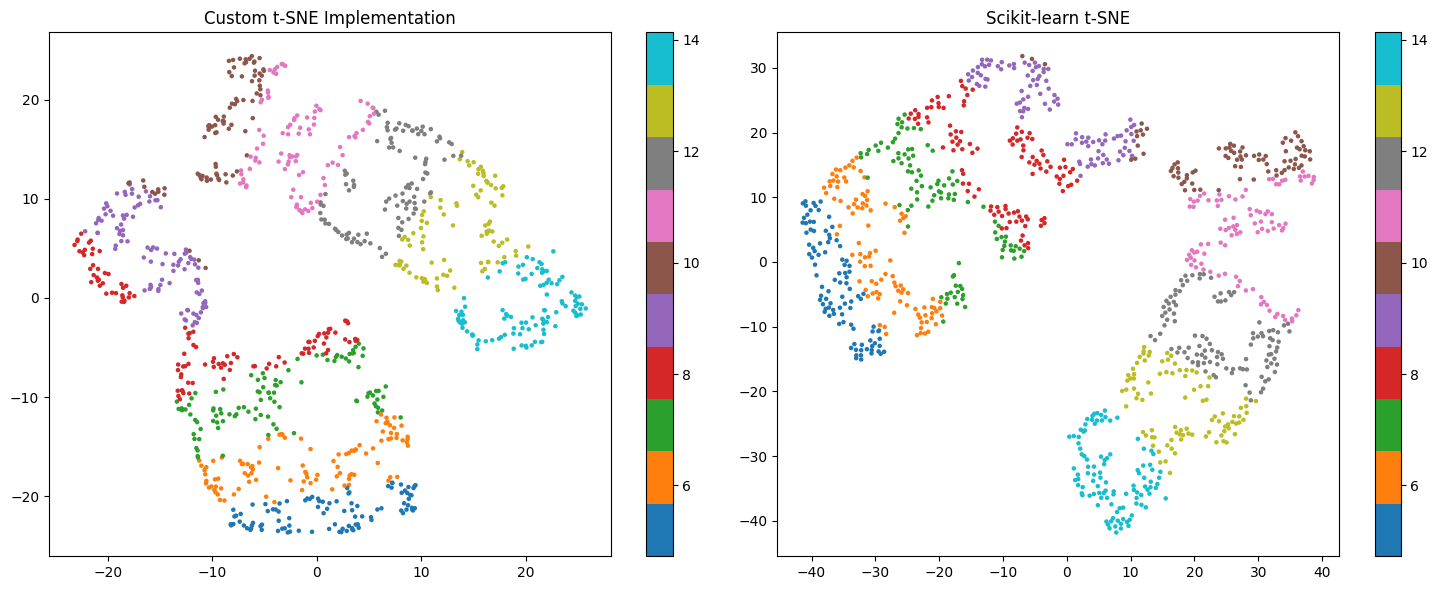

In [ ]:
def gradient(P, Q, Y, D):
    """D is the squared Euclidean distance matrix from compute_low_dimensional_affinities"""
    PQ = P - Q
    inv_distances = 1 / (1 + D)
    np.fill_diagonal(inv_distances, 0)
    weighted_differences = np.expand_dims(
        PQ * inv_distances, axis=2) * (Y[:, None, :] - Y[None, :, :])
    return 4 * np.sum(weighted_differences, axis=1)


def tsne(X, random_state, dim=2, perplexity=30.0, lr=200, n_iter=1000, early_exaggeration=4.0, exaggeration_iter=100, momentum=0.5, final_momentum=0.8):
    """
    Optimized t-SNE function with improvements.
    """
    if random_state is not None:
        np.random.seed(random_state)
    n = X.shape[0]
    Y = np.random.normal(0, 1e-4, (n, dim))
    P = pairwise_affinities(X, perplexity)
    P *= early_exaggeration
    velocity = np.zeros_like(Y)

    for i in range(n_iter):
        Q, D = low_dimensional_affinities(Y)  # Return both Q and D
        grad = gradient(P, Q, Y, D)  # Pass D to gradient
        if i == exaggeration_iter:
            P /= early_exaggeration
        mom = final_momentum if i > exaggeration_iter else momentum
        velocity = mom * velocity - lr * grad
        Y += velocity

        if i % 100 == 0 or i == n_iter - 1:
            loss = np.sum(P * np.log((P + 1e-12) / (Q + 1e-12)))
            print(f"Iteration {i}: KL divergence = {loss:.4f}")

    return Y

# --- Testing and Comparison ---


# 1. Custom t-SNE
print("Running custom t-SNE...")
start = time.time()
custom_tsne = tsne(data, dim=2, n_iter=500,
                   perplexity=30, lr=200, random_state=0)
custom_time = time.time() - start

# 2. Scikit-learn t-SNE
print("\nRunning scikit-learn t-SNE...")
start = time.time()
sk_tsne = TSNE(n_components=2, perplexity=30, max_iter=500, learning_rate=200,
               random_state=0, method='exact', init='random', verbose=1).fit_transform(data)
sk_time = time.time() - start

print(f"\nCustom t-SNE time: {custom_time:.2f}s")
print(f"Scikit-learn t-SNE time: {sk_time:.2f}s")

# --- Visualization ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sc1 = ax1.scatter(custom_tsne[:, 0], custom_tsne[:,
                  1], c=color, cmap='tab10', s=5)
ax1.set_title('Custom t-SNE Implementation')
fig.colorbar(sc1, ax=ax1)

sc2 = ax2.scatter(sk_tsne[:, 0], sk_tsne[:, 1], c=color, cmap='tab10', s=5)
ax2.set_title('Scikit-learn t-SNE')
fig.colorbar(sc2, ax=ax2)

plt.tight_layout()
plt.show()